<a href="https://colab.research.google.com/github/agrawalabr/deeplearning/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP - Contrastive Vision-Language Pre-training, Deep Learning (ECE-GY-7123)
- Name: Abhishek Agrawal
- Net-id: aa9360

##### Question 2(c): We observe that increasing the model scale generally leads to improved performance. Specifically, using deeper image encoders like ResNet-50 produces more detailed visual features, while larger text encoders such as BERT-base offer better contextual understanding of prompts. Models with balanced scaling between image and text encoders (e.g., ResNet-34 + BERT) tend to perform best, showing strong alignment between visual and textual representations. Additionally, larger models respond better to complex, descriptive prompts, indicating improved generalization and semantic richness. Overall, model scale positively influences qualitative performance, particularly in zero-shot image-text retrieval.

In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, BertModel, RobertaModel, DistilBertConfig, BertConfig, RobertaConfig, AutoTokenizer


<ipython-input-1-e1732cef63a4>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
!pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = 'agrawalabr01'
os.environ['KAGGLE_KEY'] = '71df4e7d2ed7900e07699d105850d7d2'

### For Flickr 8k
!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip

In [ ]:
# Define configuration class with hyperparameters
class config:
    debug = False
    image_path = "/content/Images"  # Path to images
    captions_path = "/content"      # Path to captions
    batch_size = 32                # Batch size for training
    num_workers = 2                # Number of workers for data loading
    head_lr = 1e-3                 # Learning rate for projection heads
    image_encoder_lr = 1e-4        # Learning rate for image encoder
    text_encoder_lr = 1e-5         # Learning rate for text encoder
    weight_decay = 1e-3            # Weight decay for optimization
    patience = 1                   # Patience for LR scheduler
    factor = 0.8                   # Factor for LR reduction
    epochs = 2                     # Number of training epochs
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Device to use
    model_name = 'resnet50'        # Vision encoder model (to be set per model)
    image_embedding = 2048         # Image embedding size (to be set per model)
    text_encoder_model = "distilbert-base-uncased"  # Text encoder model (to be set per model)
    text_embedding = 768           # Text embedding size (fixed for base models)
    text_tokenizer = "distilbert-base-uncased"  # Tokenizer (to be set per model)
    max_length = 200               # Max length for text tokens
    pretrained = True              # Use pretrained weights
    trainable = True               # Allow fine-tuning
    temperature = 1.0              # Temperature for loss scaling
    size = 224                     # Image resize dimensions
    num_projection_layers = 1      # Number of layers in projection head
    projection_dim = 256           # Dimension of projected embeddings
    dropout = 0.3                  # Dropout rate in projection head

In [ ]:
# Dataset class to handle image-caption pairs
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        Initialize dataset with images, captions, tokenizer, and transforms.
        image_filenames and captions must align in length.
        """
        self.image_filenames = image_filenames
        self.captions = list(captions)
        # Tokenize captions
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=config.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        # Prepare tokenized text data
        item = {key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()}
        # Load and preprocess image
        image = cv2.imread(f"{config.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()  # Convert to CHW format
        item['caption'] = self.captions[idx]
        return item

    def __len__(self):
        return len(self.captions)

# Function to split data into train and validation sets
def make_train_valid_dfs():
    """Create train and validation dataframes from captions.csv."""
    dataframe = pd.read_csv(f"{config.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not config.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)  # For reproducibility
    valid_ids = np.random.choice(image_ids, size=int(0.2 * len(image_ids)), replace=False)
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

# Function to build data loaders
def build_loaders(dataframe, tokenizer, mode):
    """Build data loader for training or validation."""
    transforms = A.Compose([
        A.Resize(config.size, config.size),  # Resize images
        A.Normalize(max_pixel_value=255.0),  # Normalize pixel values
    ])
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [ ]:
# Image encoder using ResNet models from timm
class ImageEncoder(nn.Module):
    def __init__(self, model_name=config.model_name, pretrained=config.pretrained, trainable=config.trainable):
        """Initialize image encoder with specified ResNet model."""
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool="avg")
        for p in self.model.parameters():
            p.requires_grad = trainable  # Allow or freeze parameters

    def forward(self, x):
        return self.model(x)  # Output embedding (512 for ResNet-18/34, 2048 for ResNet-50)

# Text encoder supporting multiple transformer models
class TextEncoder(nn.Module):
    def __init__(self, model_name=config.text_encoder_model, pretrained=config.pretrained, trainable=config.trainable):
        """Initialize text encoder with DistilBERT, BERT, or RoBERTa."""
        super().__init__()
        # Select model based on name
        if "distilbert" in model_name:
            model_class = DistilBertModel
            config_class = DistilBertConfig
        elif "bert" in model_name:
            model_class = BertModel
            config_class = BertConfig
        elif "roberta" in model_name:
            model_class = RobertaModel
            config_class = RobertaConfig
        else:
            raise ValueError("Unsupported text encoder model")

        self.model = model_class.from_pretrained(model_name) if pretrained else model_class(config=config_class())
        for p in self.model.parameters():
            p.requires_grad = trainable
        self.target_token_idx = 0  # Use CLS token embedding

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return output.last_hidden_state[:, self.target_token_idx, :]  # Return CLS token embedding (768)

# Projection head to align embedding dimensions
class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim, projection_dim=config.projection_dim, dropout=config.dropout):
        """Project embeddings to a common dimension (256)."""
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected  # Residual connection
        x = self.layer_norm(x)
        return x

# Full CLIP model
class CLIPModel(nn.Module):
    def __init__(self, temperature=config.temperature, image_embedding=config.image_embedding, text_embedding=config.text_embedding):
        """Combine image and text encoders with projection heads."""
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Encode images and text
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        # Project to common space
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)
        # Compute loss
        batch_size = len(image_embeddings)
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax((images_similarity + texts_similarity) / 2 * self.temperature, dim=-1)
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss = (images_loss + texts_loss) / 2.0
        return loss.mean()

# Helper function for cross-entropy loss
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    return loss if reduction == "none" else loss.mean()

In [ ]:
# Helper class to track average metrics
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        return f"{self.name}: {self.avg:.4f}"

# Get learning rate from optimizer
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

# Train one epoch
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(config.device) for k, v in batch.items() if k != "caption"}
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            loss = model(batch)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if step == "batch":
            lr_scheduler.step()
        loss_meter.update(loss.item(), batch["image"].size(0))
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

# Validate one epoch
def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(config.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        loss_meter.update(loss.item(), batch["image"].size(0))
        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

<ipython-input-6-dee7f3d1d1a6>:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
import os
import pandas as pd

captions_path = '/content/captions.txt'
save_path = '/content/captions.csv'

df = pd.read_csv(captions_path)
df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
df.to_csv(save_path, index=False)

In [ ]:
# Define the three model configurations
model_configs = [
    {"model_name": "resnet18", "image_embedding": 512, "text_encoder_model": "distilbert-base-uncased", "save_path": "best_model1.pt"},
    {"model_name": "resnet34", "image_embedding": 512, "text_encoder_model": "bert-base-uncased", "save_path": "best_model2.pt"},
    {"model_name": "resnet50", "image_embedding": 2048, "text_encoder_model": "distilbert-base-uncased", "save_path": "best_model3.pt"}
]

# Train each model
for cfg in model_configs:
    # Set configuration for this model
    config.model_name = cfg["model_name"]
    config.image_embedding = cfg["image_embedding"]
    config.text_encoder_model = cfg["text_encoder_model"]
    config.text_tokenizer = cfg["text_encoder_model"]  # Use model name as tokenizer identifier

    # Prepare data
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = AutoTokenizer.from_pretrained(config.text_tokenizer)  # Load appropriate tokenizer
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    # Initialize model and optimizer
    model = CLIPModel().to(config.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": config.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": config.text_encoder_lr},
        {"params": itertools.chain(model.image_projection.parameters(), model.text_projection.parameters()),
         "lr": config.head_lr, "weight_decay": config.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=config.patience, factor=config.factor)
    step = "epoch"
    best_loss = float('inf')

    # Training loop
    for epoch in range(config.epochs):
        print(f"Epoch: {epoch + 1} for {cfg['model_name']} + {cfg['text_encoder_model']}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), cfg["save_path"])
            print("Saved Best Model!")
        lr_scheduler.step(valid_loss.avg)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch: 1 for resnet18 + distilbert-base-uncased


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2 for resnet18 + distilbert-base-uncased


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Epoch: 1 for resnet34 + bert-base-uncased


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2 for resnet34 + bert-base-uncased


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 1 for resnet50 + distilbert-base-uncased


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2 for resnet50 + distilbert-base-uncased


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

In [ ]:
# Compute image embeddings for validation set
def get_image_embeddings(valid_df, model_path):
    """Load model and compute embeddings for validation images."""
    tokenizer = AutoTokenizer.from_pretrained(config.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    model = CLIPModel().to(config.device)
    model.load_state_dict(torch.load(model_path, map_location=config.device))
    model.eval()
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(config.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

# Find and display matching images for a text query
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    """Embed query and find top matching images."""
    tokenizer = AutoTokenizer.from_pretrained(config.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {key: torch.tensor(values).to(config.device) for key, values in encoded_query.items()}
    with torch.no_grad():
        text_features = model.text_encoder(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        text_embeddings = model.text_projection(text_features)
    # Normalize embeddings and compute similarity
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]  # Subsample to get n matches
    # Display images in a grid
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{config.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    plt.show()

Question 2(c): We observe that increasing the model scale generally leads to improved performance. Specifically, using deeper image encoders like ResNet-50 produces more detailed visual features, while larger text encoders such as BERT-base offer better contextual understanding of prompts. Models with balanced scaling between image and text encoders (e.g., ResNet-34 + BERT) tend to perform best, showing strong alignment between visual and textual representations. Additionally, larger models respond better to complex, descriptive prompts, indicating improved generalization and semantic richness. Overall, model scale positively influences qualitative performance, particularly in zero-shot image-text retrieval.

  0%|          | 0/253 [00:00<?, ?it/s]

Model: resnet18 + distilbert-base-uncased, Prompt: a barefoot child in a yellow raincoat chasing pigeons across a foggy cobblestone plaza


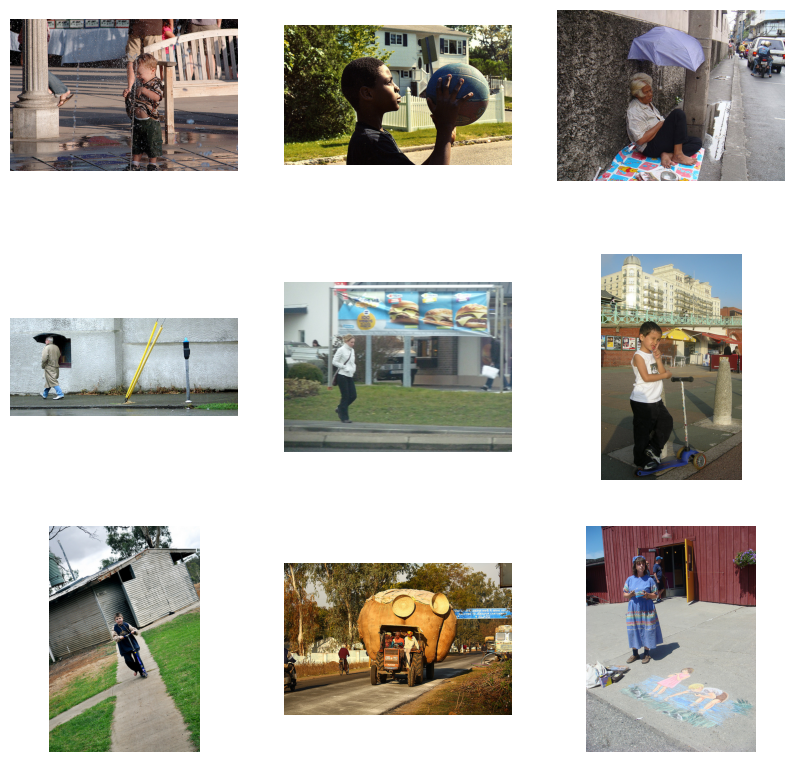

Model: resnet18 + distilbert-base-uncased, Prompt: a skateboarder mid-air performing a trick beneath a graffiti-covered urban overpass at sunset


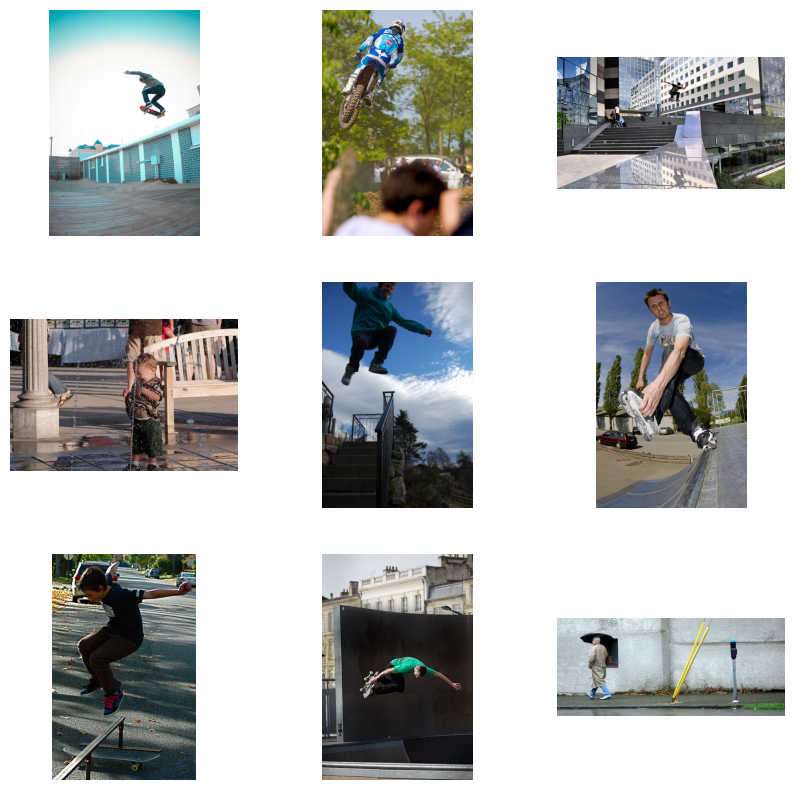

  0%|          | 0/253 [00:00<?, ?it/s]

Model: resnet34 + bert-base-uncased, Prompt: a barefoot child in a yellow raincoat chasing pigeons across a foggy cobblestone plaza


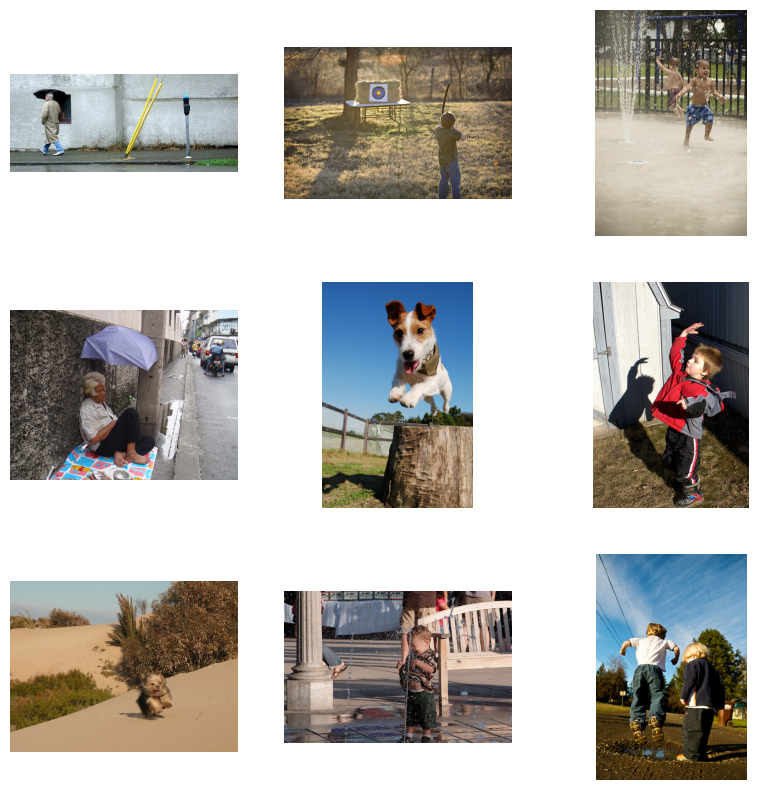

Model: resnet34 + bert-base-uncased, Prompt: a skateboarder mid-air performing a trick beneath a graffiti-covered urban overpass at sunset


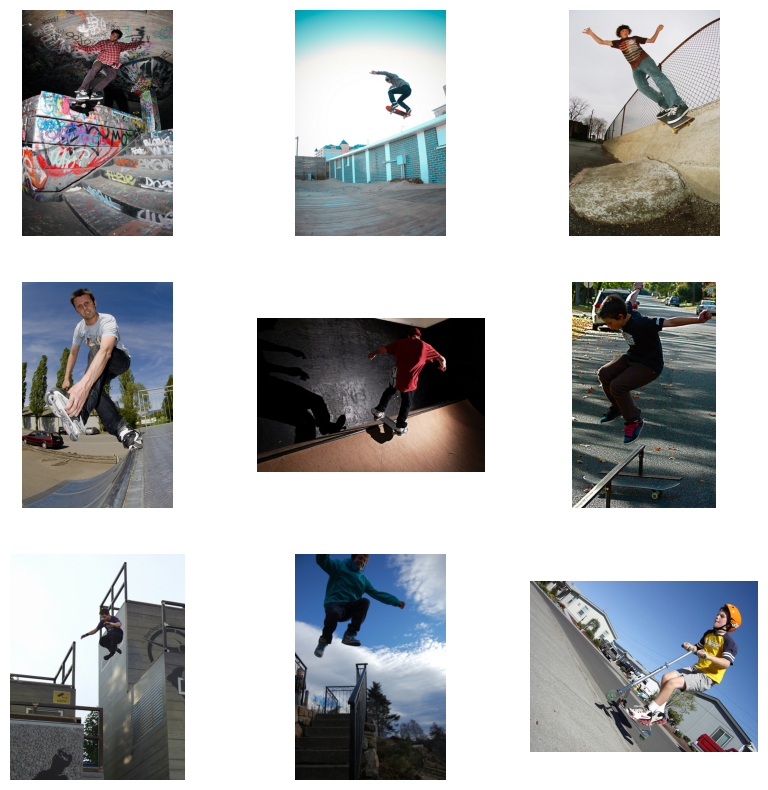

  0%|          | 0/253 [00:00<?, ?it/s]

Model: resnet50 + distilbert-base-uncased, Prompt: a barefoot child in a yellow raincoat chasing pigeons across a foggy cobblestone plaza


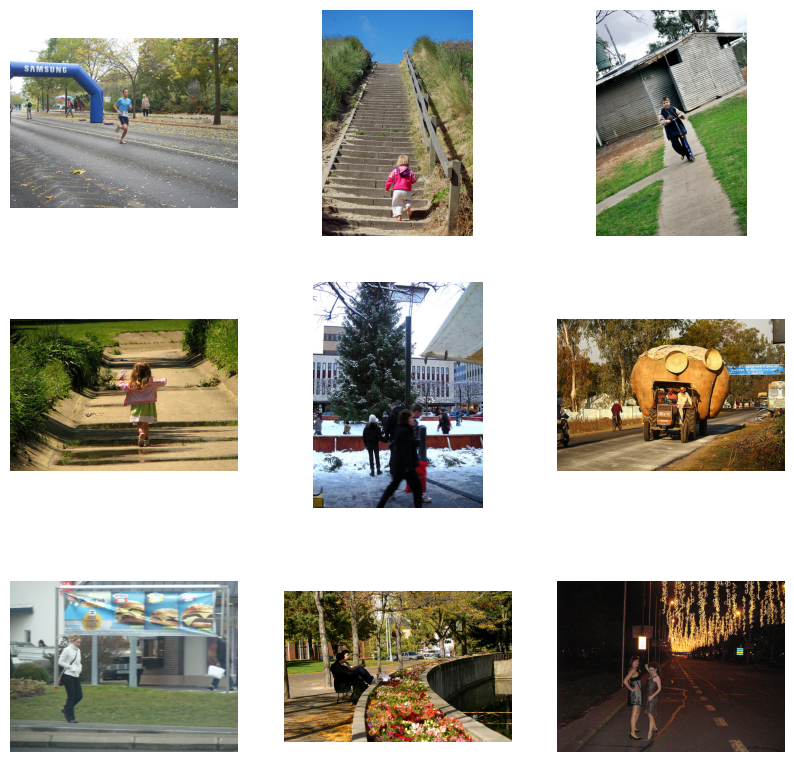

Model: resnet50 + distilbert-base-uncased, Prompt: a skateboarder mid-air performing a trick beneath a graffiti-covered urban overpass at sunset


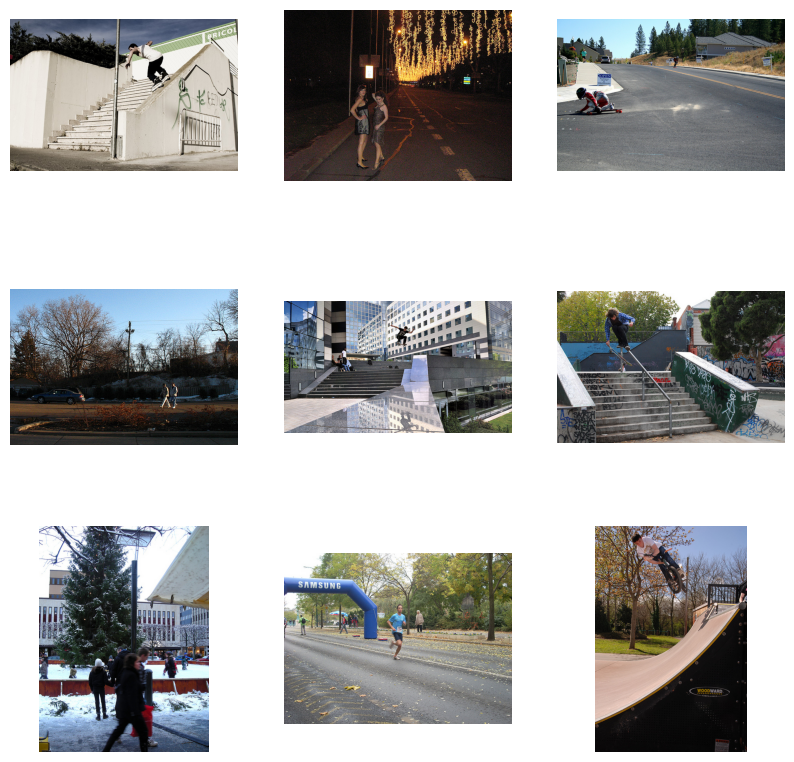

In [ ]:
# Define text prompts
prompts = [
    "a barefoot child in a yellow raincoat chasing pigeons across a foggy cobblestone plaza",
    "a skateboarder mid-air performing a trick beneath a graffiti-covered urban overpass at sunset"
]

# Test each model
for cfg in model_configs:
    config.model_name = cfg["model_name"]
    config.image_embedding = cfg["image_embedding"]
    config.text_encoder_model = cfg["text_encoder_model"]
    config.text_tokenizer = cfg["text_encoder_model"]

    # Load model and embeddings
    model, image_embeddings = get_image_embeddings(valid_df, cfg["save_path"])
    for prompt in prompts:
        print(f"Model: {cfg['model_name']} + {cfg['text_encoder_model']}, Prompt: {prompt}")
        find_matches(model, image_embeddings, query=prompt, image_filenames=valid_df['image'].values, n=9)

We observe that increasing the model scale generally leads to improved performance. Specifically, using deeper image encoders like ResNet-50 produces more detailed visual features, while larger text encoders such as BERT-base offer better contextual understanding of prompts. Models with balanced scaling between image and text encoders (e.g., ResNet-34 + BERT) tend to perform best, showing strong alignment between visual and textual representations. Additionally, larger models respond better to complex, descriptive prompts, indicating improved generalization and semantic richness. Overall, model scale positively influences qualitative performance, particularly in zero-shot image-text retrieval.